# [SIIM-FISABIO-RSNA COVID-19 Detection](https://www.kaggle.com/c/siim-covid19-detection)
> Identify and localize COVID-19 abnormalities on chest radiographs

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26680/logos/header.png)

# How to Create TFRecord

In [41]:
SEED  = 42
FOLDS = 5
DIM   = 512
IMAGE_DIM = 640
MASK_DIM = 32

# Importing Packages

In [42]:
import numpy as np 
import pandas as pd 
import os, shutil
from glob import glob
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import random
tqdm.pandas()

In [43]:
np.random.seed(SEED)
random.seed(SEED)

In [44]:
train_df = pd.read_csv(f'../input/siimcovid19-{DIM}-jpg-image-dataset/train.csv')
train_df['image_path'] = F'../input/siimcovid19-{DIM}-jpg-image-dataset/train/'+train_df.image_id+'.jpg'
train_df.head(2)

,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,filepath,image_path
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0,/kaggle/input/siim-covid19-detection/train/577...,../input/siimcovid19-512-jpg-image-dataset/tra...
1,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f,1,0,0,0,/kaggle/input/siim-covid19-detection/train/ff0...,../input/siimcovid19-512-jpg-image-dataset/tra...


# ClassName and ClassLabel Map

In [45]:
name2label = {'Typical Appearance': 3,
 'Indeterminate Appearance': 1,
 'Atypical Appearance': 2,
 'Negative for Pneumonia': 0}
class_names = list(name2label.keys())
label2name = {v:k for k, v in name2label.items()}
train_df['class_name']  = train_df.progress_apply(lambda row:row[class_names].iloc[[row[class_names].values.argmax()]].index.tolist()[0], axis=1)
train_df['class_label'] = train_df.class_name.map(name2label)
train_df.head()

  0%|          | 0/6334 [00:00<?, ?it/s]

,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,filepath,image_path,class_name,class_label
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0,/kaggle/input/siim-covid19-detection/train/577...,../input/siimcovid19-512-jpg-image-dataset/tra...,Typical Appearance,3
1,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f,1,0,0,0,/kaggle/input/siim-covid19-detection/train/ff0...,../input/siimcovid19-512-jpg-image-dataset/tra...,Negative for Pneumonia,0
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc,0,1,0,0,/kaggle/input/siim-covid19-detection/train/9d5...,../input/siimcovid19-512-jpg-image-dataset/tra...,Typical Appearance,3
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f,0,0,0,1,/kaggle/input/siim-covid19-detection/train/28d...,../input/siimcovid19-512-jpg-image-dataset/tra...,Atypical Appearance,2
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891,0,1,0,0,/kaggle/input/siim-covid19-detection/train/dfd...,../input/siimcovid19-512-jpg-image-dataset/tra...,Typical Appearance,3


# Stratified KFold by Groups

In [46]:
train_df['image_path'] = train_df['image_path'].str.replace("../input/siimcovid19-512-jpg-image-dataset/train/", "../input/covid19-detection-890pxpng-study/train/")
train_df['image_path'] = train_df['image_path'].str.replace(".jpg", ".png")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [47]:
train_df['mask_path'] = train_df['image_path']

In [48]:
from sklearn.model_selection import GroupKFold, StratifiedKFold
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.StudyInstanceUID.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,filepath,image_path,class_name,class_label,mask_path,fold
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0,/kaggle/input/siim-covid19-detection/train/577...,../input/covid19-detection-890pxpng-study/trai...,Typical Appearance,3,../input/covid19-detection-890pxpng-study/trai...,4
1,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f,1,0,0,0,/kaggle/input/siim-covid19-detection/train/ff0...,../input/covid19-detection-890pxpng-study/trai...,Negative for Pneumonia,0,../input/covid19-detection-890pxpng-study/trai...,0
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc,0,1,0,0,/kaggle/input/siim-covid19-detection/train/9d5...,../input/covid19-detection-890pxpng-study/trai...,Typical Appearance,3,../input/covid19-detection-890pxpng-study/trai...,4
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f,0,0,0,1,/kaggle/input/siim-covid19-detection/train/28d...,../input/covid19-detection-890pxpng-study/trai...,Atypical Appearance,2,../input/covid19-detection-890pxpng-study/trai...,1
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891,0,1,0,0,/kaggle/input/siim-covid19-detection/train/dfd...,../input/covid19-detection-890pxpng-study/trai...,Typical Appearance,3,../input/covid19-detection-890pxpng-study/trai...,3


<!-- # Check the signals
From the [dataset information](https://www.kaggle.com/c/seti-breakthrough-listen/overview/data-information),
>>
Not all of the “needle” signals look like diagonal lines, and they may not be present for the entirety of all three “A” observations, but what they do have in common is that they are only present in some or all of the “A” observations (panels **1**, **3**, and **5** in the cadence snippets).

 -->

In [49]:
train_df.image_path[0]

'../input/covid19-detection-890pxpng-study/train/000a312787f2.png'

In [50]:
os.path.isfile(train_df.image_path.iloc[100])

True

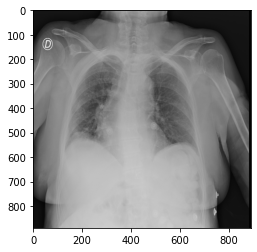

In [54]:
import matplotlib.pyplot as plt
import cv2
def load_image(path, mask_path, dim=IMAGE_DIM, ch=3, mask_dim=MASK_DIM):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE if ch==None else cv2.IMREAD_COLOR)
    if img.shape[:2]!=(dim,dim) and dim!=-1:
        img = cv2.resize(img, dsize=(dim,dim), interpolation=cv2.INTER_AREA)
    if os.path.isfile(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (MASK_DIM,MASK_DIM))
    else:
        mask = np.zeros(size=(MASK_DIM,MASK_DIM))
    return img, mask

plt.imshow(load_image(train_df.image_path.iloc[100], train_df.mask_path.iloc[100],
                      ch=3,dim=-1,mask_dim=32)[0])

# Visualize Channels

# TFRecord Data

In [55]:
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Writng TFRecord (Train)

In [56]:
def train_serialize_example(feature0, feature1, feature2, feature3, feature4):
    feature = {
      'image'         : _bytes_feature(feature0),
      'image_id'      : _bytes_feature(feature1),
      'group'         : _bytes_feature(feature2),    
      'target'        : _int64_feature(feature3),
      'mask'          : _bytes_feature(feature4)
  }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [57]:
show=True
folds = train_df.fold.unique().tolist()
for fold in tqdm(folds): # create tfrecord for each fold
    fold_df = train_df[train_df.fold==fold]
    if show:
        print(); print('Writing TFRecord of fold %i :'%(fold))  
    with tf.io.TFRecordWriter('train%.2i-%i.tfrec'%(fold,fold_df.shape[0])) as writer:
        samples = fold_df.shape[0]
#         samples = 200
        it = tqdm(range(samples)) if show else range(samples)
        for k in it: # images in fold
            row = fold_df.iloc[k,:]
            #plt.imshow(load_image(train_df.image_path.iloc[100], train_df.mask_path.iloc[100],
            #          ch=3,dim=-1,mask_dim=32)[0])
            image, mask      = load_image(row['image_path'], 
                                          row['mask_path'],
                                          dim=IMAGE_DIM,
                                          mask_dim=MASK_DIM)
            image_id   = row['image_id']
            group      = row['StudyInstanceUID']
            target     = np.array(row['class_label'], dtype=np.uint8)
            example  = train_serialize_example(
                cv2.imencode('.jpg', image, (cv2.IMWRITE_JPEG_QUALITY, 96))[1].tobytes(),
                str.encode(image_id),
                str.encode(group),
                target,
                cv2.imencode('.jpg', mask, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tobytes()
                )
            writer.write(example)
        if show:
            filepath = 'train%.2i-%i.tfrec'%(fold,fold_df.shape[0])
            filename = filepath.split('/')[-1]
            filesize = os.path.getsize(filepath)/10**6
            print(filename,':',np.around(filesize, 2),'MB')

  0%|          | 0/5 [00:00<?, ?it/s]


Writing TFRecord of fold 4 :


  0%|          | 0/1266 [00:00<?, ?it/s]

train04-1266.tfrec : 116.62 MB

Writing TFRecord of fold 0 :


  0%|          | 0/1267 [00:00<?, ?it/s]

train00-1267.tfrec : 118.44 MB

Writing TFRecord of fold 1 :


  0%|          | 0/1267 [00:00<?, ?it/s]

train01-1267.tfrec : 117.92 MB

Writing TFRecord of fold 3 :


  0%|          | 0/1267 [00:00<?, ?it/s]

train03-1267.tfrec : 116.97 MB

Writing TFRecord of fold 2 :


  0%|          | 0/1267 [00:00<?, ?it/s]

train02-1267.tfrec : 117.42 MB


# Writing TFRecord (Test)

In [ ]:
# def test_serialize_example(feature0, feature1, feature2):
#     feature = {
#       'image'         : _bytes_feature(feature0),
#       'image_id'      : _bytes_feature(feature1),
#       'group'         : _bytes_feature(feature2),    
#   }
#     example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
#     return example_proto.SerializeToString()

In [ ]:
# show  = True
# folds = 10
# l     = int(np.ceil(test_df.shape[0]/folds))
# for fold in tqdm(range(folds)): # create tfrecord for each fold
#     fold_df = test_df.iloc[l*fold:l*(fold+1)]
#     if show:
#         print(); print('Writing TFRecord of fold %i :'%(fold))  
#     with tf.io.TFRecordWriter('test%.2i-%i.tfrec'%(fold,fold_df.shape[0])) as writer:
#         samples = fold_df.shape[0]
# #         samples = 200
#         it = tqdm(range(samples)) if show else range(samples)
#         for k in it: # images in fold
#             row = fold_df.iloc[k,:]
#             image      = load_signal(row['filepath'], dim=DIM)
#             image      = image[...,::-1] # rgb -> bgr, we'll get the rgb form after decoding the tfrec
#             image_id   = row['id']
#             group      = row['group']
#             example  = test_serialize_example(
#                 cv2.imencode('.png', image)[1].tobytes(),
#                 str.encode(image_id),
#                 str.encode(group),
#                 )
#             writer.write(example)
#         if show:
#             filepath = 'test%.2i-%i.tfrec'%(fold,fold_df.shape[0])
#             filename = filepath.split('/')[-1]
#             filesize = os.path.getsize(filepath)/10**6
#             print(filename,':',np.around(filesize, 2),'MB')

# Reading TFRecord

In [69]:
import re, math
def decode_image(image_data):
    image = tf.image.decode_png(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image
def decode_mask_image(image_data):
    image = tf.image.decode_png(image_data, channels=1)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*MASK_SIZE, 1]) # explicit size needed for TPU
    return image
def prepare_target(target):    
    target = tf.cast(target, tf.float32)            
    target = tf.reshape(target, [1])         
    return target

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "mask" : tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image  = tf.reshape(image, [IMAGE_DIM, IMAGE_DIM, 3])
    target = prepare_target(example['target'])
    mask = decode_mask_image(example['mask'])
    mask = tf.reshape(mask, [MASK_DIM,MASK_DIM,1])
    return image, target, mask # returns a dataset of (image, label) pairs

def load_dataset(fileids, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(fileids, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(20, seed=SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(fileids):
    # the number of data items is written in the id of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) for fileid in fileids]
    return np.sum(n)

# Visual

In [70]:
def display_batch(batch, size=2):
    imgs, tars, mask = batch
    plt.figure(figsize=(size*5, 5))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        plt.title(f'class: {label2name[tars[img_idx].numpy()[0]]}', fontsize=15)
        plt.imshow(imgs[img_idx,:, :, :])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

# Total Images

In [71]:
# INITIALIZE VARIABLES
IMAGE_SIZE= [IMAGE_DIM,IMAGE_DIM];
MASK_SIZE = [MASK_DIM,MASK_DIM]
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('train*.tfrec')
TEST_FILENAMES     = tf.io.gfile.glob('test*.tfrec')
print('There are %i train & %i test images'%(count_data_items(TRAINING_FILENAMES), count_data_items(TEST_FILENAMES)))

There are 6334 train & 0 test images


# Once Batch Image

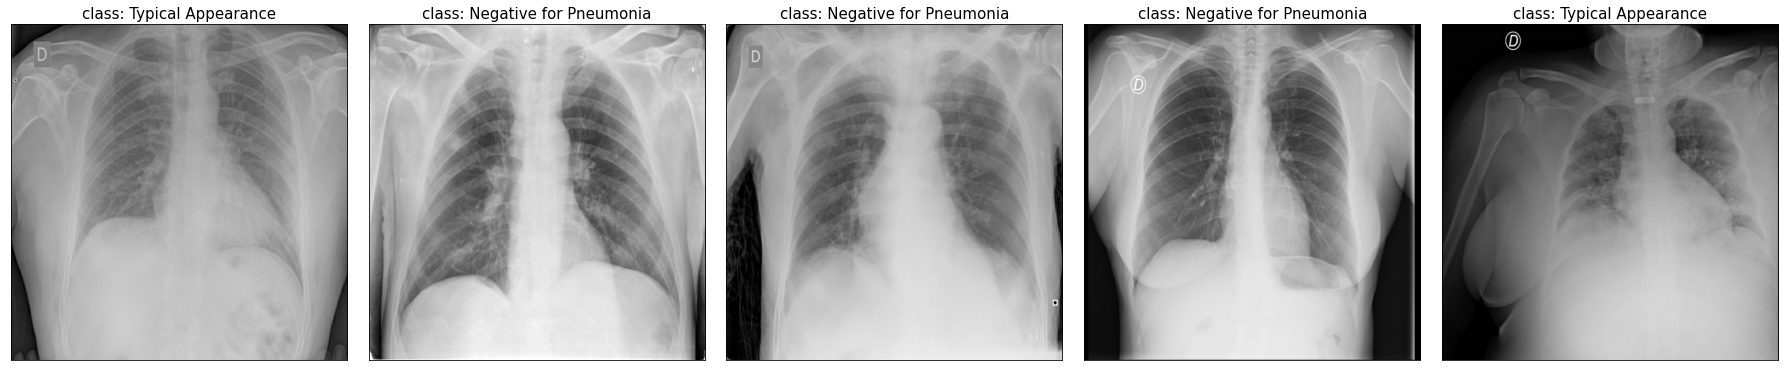

In [72]:
# DISPLAY TRAIN IMAGES
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = next(iter(training_dataset))
display_batch(train_batch, 5);

In [74]:
img, label, mask = train_batch
np.unique(label.numpy(), return_counts=True)

(array([0., 1., 2., 3.], dtype=float32), array([ 8,  1,  1, 10]))